In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
recalc_means = False #recalculate the groupwise mean stats set to False to load from file

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
epoch_db = h5py.File('../02_imaging_post_processing/epoch_db_nnls_fits_bk_sub_F.hdf5','a')

In [3]:
data = dict()
data['exp_names'] = np.array(epoch_db['exp_names'])
data['fly_numbers'] = np.array(epoch_db['fly_numbers'])
data['genotypes'] = np.array(epoch_db['genotypes'])
data['signal_data'] = np.array(epoch_db['signal_data'])
data['signal_names'] = np.array(epoch_db['signal_names'])
data['trial_names'] = np.array(epoch_db['trial_names'])
data['flt_samples'] = np.array(epoch_db['flt_samples'])

In [4]:
# function to get the timebase using the trial name (yaw_left)
def get_xio(trial_name):
    xi = np.linspace(0,23,1150)
    #print trial_name
    if trial_name in ['ascending','descending','yaw_left','yaw_right','progressive','regressive']:
        xi -= 10.0
    if 'pth_roll' in trial_name:
        xi -= 7.0
    if 'flight' in trial_name:
        xi -= 5.0
    else:
        return xi
    return xi

In [5]:
import group_data as gd
trial_types = set(data['trial_names'])
test_set = list(trial_types.difference(['flight_starts','flight_stops','stripe_fix']))
fly_set = set(gd.GMR22H05_list) | set(gd.GMR22H05_pr_list) | set(gd.GMR22H05_prc_list)
#fly_set = set(gd.GMR40D04_pr_list)

In [6]:
#mask out the data so only the trial types in test_set will be included
mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for trial_name in test_set:
    mask = mask | (data['trial_names'] == trial_name)

#now mask out the data to only include the flys in fly_set
fly_mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for fly in fly_set:
    fly_mask = fly_mask | (data['fly_numbers'] == fly)
mask = mask & fly_mask
#data['trial_names'] == list(test_set)[0])

In [7]:
import cPickle
if recalc_means:
    means = fly_means(data,mask)
    with open('mean_dict_22H05.cpkl','wb') as fi: cPickle.dump(means,fi)
else:
    with open('mean_dict_22H05.cpkl','rb') as fi: means = cPickle.load(fi)

In [8]:
trial_to_label = dict()
[trial_to_label.update({tname:tname}) for tname in trial_types]

[trial_to_label.update({tname:'PR' + tname.split('_')[-1]}) 
    for tname in trial_types if 'pth_roll' in tname]

trial_to_label['step_roll_yaw_000'] = 'RL'#\n00'
trial_to_label['step_roll_yaw_090'] = 'YR'#\n90'
trial_to_label['step_roll_yaw_180'] = 'RR'#\n180'
trial_to_label['step_roll_yaw_270'] = 'YL'#\n270'

trial_to_label['ascending'] = 'ASC'
trial_to_label['descending'] = 'DEC'
trial_to_label['progressive'] = 'PRO'
trial_to_label['regressive'] = 'REG'

trial_to_label['pth_roll_0'] = 'PU'#\n00'
trial_to_label['pth_roll_90'] = 'RR'#\n90'
trial_to_label['pth_roll_180'] = 'PD'#\n180'
trial_to_label['pth_roll_270'] = 'RL'#\n270'

trial_to_label['yaw_left'] = 'YR'
trial_to_label['yaw_right'] = 'YL'

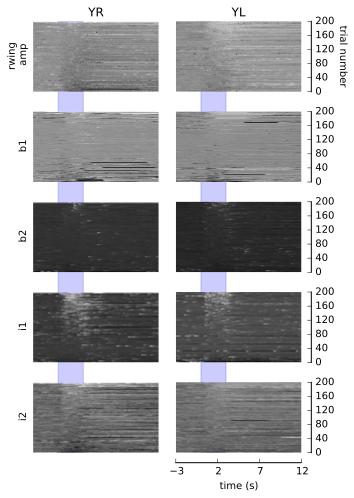

In [13]:
#############################
## Plot example raster images
#############################

signal = 'iii3'
trial = 'yaw_left'
col_keys = ['yaw_left','yaw_right']
row_keys = ['Ph1','b1','b2','i1','i2']
rows = len(row_keys)
cols = len(col_keys)

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]
row_labels_right[0] = 'trial number'

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-3,12) for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = [trial_to_label[trial] for trial in col_keys]

show_spines_left = False
show_spines_right = [True for j in range(rows)]

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [6 for j in range(rows)]
xtick_numbers = [4 for i in range(cols)]

def norm_sig(sig):
    sig -= np.min(sig)
    sig /= np.max(sig)
    return sig

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    signal = row_keys[row]
    trial = col_keys[col]
    selection = (data['signal_names'] == signal) & \
                (data['trial_names'] == trial) & \
                (data['flt_samples'] > 800) & \
                mask
    data_selection = data['signal_data'][selection,:]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>0) & (xi <3))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    sort_idx = argsort(mean(subtracted_selection[:,stim_idx],axis = 1))
    sorted_selection = subtracted_selection[sort_idx[::-1]]
    imshow(sorted_selection,aspect = 'auto',cmap = cm.gray,extent = (xi[0],xi[-1],0,shape(sorted_selection)[0]))
    sig = np.mean(sorted_selection,axis = 0)
    sig = norm_sig(sig)*shape(sorted_selection)[0]
    pltrng = (xi>-3) & (xi<12)
    
    #plot(xi[pltrng],sig[pltrng],clip_on = False)
    #pf.kill_spines()
    #gca().set_xbound(-5,12)


import plotfuncs as pf
reload(pf)

pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                   rows = rows,cols = cols,
                   row_epochs = row_epochs,
                   col_epochs = col_epochs,
                   ybounds = ybounds,
                   xbounds = xbounds,
                   figsize = (5,7),
                   col_labels_top = col_labels_top,
                   col_labels_bottom = col_labels_bottom,
                   show_spines_left = show_spines_left,
                   show_spines_right = show_spines_right,
                   show_spines_bottom = show_spines_bottom,
                   row_labels_left = row_labels_left,
                   row_labels_right = row_labels_right,
                   ytick_numbers = ytick_numbers,
                   xtick_numbers = xtick_numbers)

savefig('trial_rasters.pdf')

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide


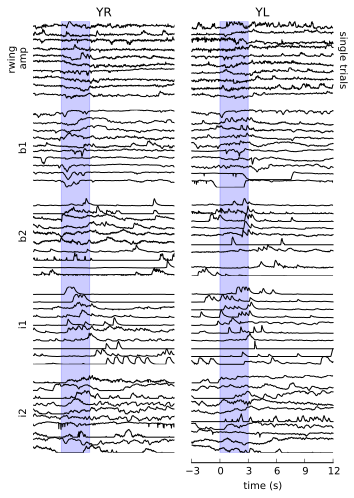

In [24]:
#############################
## Plot waterfall plots
#############################

signal = 'iii3'
trial = 'yaw_left'
col_keys = ['yaw_left','yaw_right']
row_keys = ['Ph1', 'b1','b2','i1','']
rows = len(row_keys)
cols = len(col_keys)
row_epochs = None
col_epochs  = (0,3)
pltrng = (-3,12)
row_labels_right = [None for j in range(rows)]
row_labels_right[0] = 'single trials'

nsweeps = 10
ybounds = [(0,nsweeps) for j in range(rows)] 
xbounds = [pltrng for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = [trial_to_label[trial] for trial in col_keys]

show_spines_left = False
show_spines_right = False

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [6 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]


def plot_example_traces(col,row):
    signal = row_keys[row]
    trial = col_keys[col]
    selection = (data['signal_names'] == signal) & \
                (data['trial_names'] == trial) & \
                (data['flt_samples'] > 800) & \
                mask
    
    data_selection = data['signal_data'][selection,:]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>col_epochs[0]) & (xi <col_epochs[1]))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    sort_idx = argsort(mean(subtracted_selection[:,stim_idx],axis = 1))
    sorted_selection = subtracted_selection[sort_idx[::-1]]
    
    interval = shape(sorted_selection)[0]/nsweeps
    pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
    for n in range(nsweeps):
        sig = sorted_selection[n*interval*-1-1,:]
        sig = sig[pltidx]
        plot(xi[pltidx],norm_sig(sig)+n,color = 'k')
    
reload(pf) 
pf.plot_data_matrix(plot_panel_function = plot_example_traces,
                   rows = rows,cols = cols,
                   row_epochs = row_epochs,
                   col_epochs = col_epochs,
                   ybounds = ybounds,
                   xbounds = xbounds,
                   figsize = (5,7),
                   col_labels_top = col_labels_top,
                   col_labels_bottom = col_labels_bottom,
                   show_spines_left = show_spines_left,
                   show_spines_right = show_spines_right,
                   show_spines_bottom = show_spines_bottom,
                   row_labels_left = row_labels_left,
                   row_labels_right = row_labels_right,
                   ytick_numbers = ytick_numbers,
                   xtick_numbers = xtick_numbers)

savefig('waterfall_traces.pdf')

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in divide


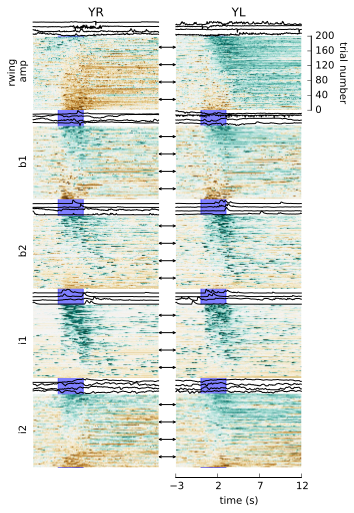

In [136]:
#############################
## Plot raster plots with a few waterfall sweeps on top
#############################

signal = 'iii3'
trial = 'yaw_left'
col_keys = ['yaw_left','yaw_right']
row_keys = ['Ph1','b1','b2','i1','i2']
rows = len(row_keys)
cols = len(col_keys)

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]
row_labels_right[0] = 'trial number'

nsweeps = 4

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-3,12) for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = [trial_to_label[trial] for trial in col_keys]

show_spines_left = False
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [6 for j in range(rows)]
xtick_numbers = [4 for i in range(cols)]


def norm_sig(sig):
    sig -= np.min(sig)
    sig /= np.max(sig)
    return sig

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    signal = row_keys[row]
    trial = col_keys[col]
    selection = (data['signal_names'] == signal) & \
                (data['trial_names'] == trial) & \
                (data['flt_samples'] > 800) & \
                mask
    data_selection = data['signal_data'][selection,:]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>0) & (xi <3))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    normed_selection = subtracted_selection/ np.nanstd(subtracted_selection,axis =1)[:,np.newaxis]
    
    sort_idx = argsort(mean(normed_selection[:,stim_idx],axis = 1))
    sorted_selection = normed_selection[sort_idx[::-1]]
    
    imshow(sorted_selection,aspect = 'auto',cmap = cm.BrBG,extent = (xi[0],xi[-1],0,shape(sorted_selection)[0]),
          vmin = -4,vmax = 4)
    #sig = np.mean(sorted_selection,axis = 0)
    #sig = norm_sig(sig)*shape(sorted_selection)[0]
    #print shape(sorted_selection)
    interval = 190/nsweeps
    
    pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
    
    for n in range(nsweeps):
        sig = sorted_selection[(n)*interval*-1-30,:]
        sig = sig[pltidx]
        plot(xi[pltidx],norm_sig(sig)*10+n*10+200,color = 'k',clip_on = False)
    #plot(xi[pltrng],sig[pltrng],clip_on = False)
    #pf.kill_spines()
    #gca().set_xbound(-5,12)


import plotfuncs as pf
reload(pf)

ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = (5,7),
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False})

#move the titles up a bit to accomidate the extra traces
ax_grid[0][0].title.set_position((0.5,1.2))
ax_grid[0][1].title.set_position((0.5,1.2))

#add annotations to indicate where the traces came from

interval = 190/nsweeps

for ax in row_ep_pans:
    sca(ax)
    for n in range(nsweeps):
        arr = matplotlib.patches.FancyArrowPatch(posA=(0.465,170-interval*(n)), posB=(0.535,170-interval*(n)), 
                              arrowstyle='<->',  
                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
                              mutation_scale=5.0, mutation_aspect=None, dpi_cor=1.0)
        gca().add_patch(arr)

    gca().set_xbound(0,1)
    gca().set_ybound(0,200)

draw()
savefig('trial_rasters_with_examples.pdf')

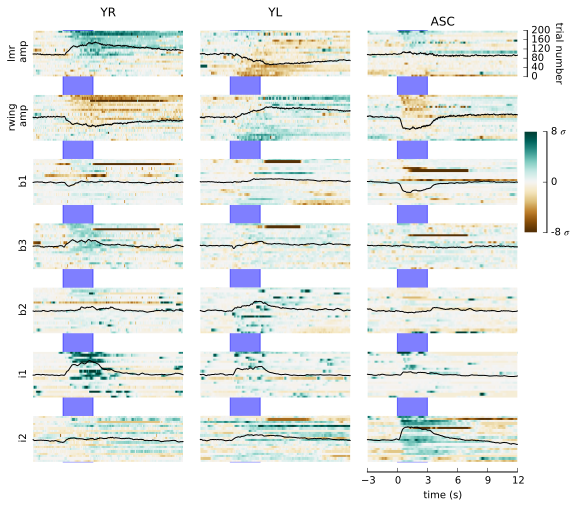

In [210]:
#############################
## Plot raster plots with a few waterfall sweeps on top, all rasters sorted by behavioral responses
#############################

signal = 'iii3'
trial = 'yaw_left'
col_keys = ['yaw_left','yaw_right','ascending']
row_keys = ['Ph2','Ph1','b1','b3','b2','i1','i2']

pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]
row_labels_right[0] = 'trial number'

nsweeps = 4

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-3,12) for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = [trial_to_label[trial] for trial in col_keys]

show_spines_left = False
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [6 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]

def get_sort_idx(signal,trial):
    selection = (data['signal_names'] == signal) & \
                (data['trial_names'] == trial) & \
                (data['flt_samples'] > 800) & \
                mask
    data_selection = data['signal_data'][selection,:]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>0) & (xi <3))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    normed_selection = subtracted_selection/ np.nanstd(subtracted_selection[:,baseline_idx])
    
    sort_idx = argsort(mean(normed_selection[:,stim_idx],axis = 1))
    return sort_idx

yleft_idx = get_sort_idx('Ph2','yaw_left')
yright_idx = get_sort_idx('Ph2','yaw_right')
tdown_idx = get_sort_idx('Ph2','ascending')
    
def norm_sig(sig):
    sig -= np.min(sig)
    sig /= np.max(sig)
    return sig

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    signal = row_keys[row]
    trial = col_keys[col]
    selection = (data['signal_names'] == signal) & \
                (data['trial_names'] == trial) & \
                (data['flt_samples'] > 800) & \
                mask
    data_selection = data['signal_data'][selection,:]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>0) & (xi <3))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    #normed_selection = subtracted_selection/ np.nanstd(subtracted_selection,axis =1)[:,np.newaxis]
    normed_selection = subtracted_selection/np.nanstd(subtracted_selection[:,baseline_idx])
    
    #sort_idx = argsort(mean(normed_selection[:,stim_idx],axis = 1))
    if trial == 'yaw_left':
        sort_idx = yleft_idx
    elif trial == 'yaw_right':
        sort_idx = yright_idx
    elif trial == 'ascending':
        sort_idx = tdown_idx
    sorted_selection = normed_selection[sort_idx[::-1]]
    
    imshow(sorted_selection[::10],aspect = 'auto',cmap = cm.BrBG,extent = (xi[0],xi[-1],0,shape(sorted_selection)[0]),
          vmin = -7,vmax = 7,interpolation = 'nearest')
    sig = np.mean(sorted_selection,axis = 0)

    #sig = norm_sig(sig)*shape(sorted_selection)[0]
    #print shape(sorted_selection)
    interval = 190/nsweeps
    
    pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
    
    #for n in range(nsweeps):
    #    sig = normed_selection[(n)*interval*-1-30,:]
    #    sig = sig[pltidx]
    #    plot(xi[pltidx],sig+n*10+200,color = 'k',clip_on = False)
    plot(xi[pltidx],sig[pltidx]*30 + 100,clip_on = False,color = 'k')
    #pf.kill_spines()
    #gca().set_xbound(-5,12)


import plotfuncs as pf
reload(pf)

ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = (8,7),
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False})

#move the titles up a bit to accomidate the extra traces
ax_grid[0][0].title.set_position((0.5,1.2))
ax_grid[0][1].title.set_position((0.5,1.2))

#add annotations to indicate where the traces came from

interval = 190/nsweeps

#for ax in row_ep_pans:
#    sca(ax)
#    for n in range(nsweeps):
#        arr = matplotlib.patches.FancyArrowPatch(posA=(0.465,170-interval*(n)), posB=(0.535,170-interval*(n)), 
#                              arrowstyle='<->',  
#                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
#                              mutation_scale=5.0, mutation_aspect=None, dpi_cor=1.0)
#        gca().add_patch(arr)

#    gca().set_xbound(0,1)
#    gca().set_ybound(0,200)

draw()
#rect = l,b,w,h
rect = 0.91,0.55,0.03,0.2
gcf().add_axes(rect)
#gca().set_ylabel(u' $\u0394$ F',rotation = -90,va = 'bottom')
gca().yaxis.set_label_position("right")
imshow(np.array([np.linspace(8,-8)]).T,cmap = cm.BrBG,extent = (0,1,-4,4))
yticks(np.linspace(-4,4,3))
gca().set_yticklabels([u'-8 $\u03C3$','0',u'8 $\u03C3$'])
pf.kill_spines()
gca().spines['right'].set_visible(True)
gca().spines['right'].set_position(('outward',10))

plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
[y.set_visible(False) for y in gca().get_yticklines()[::2]]

savefig('trial_rasters_with_examples_sorted_by_behavior.pdf')

In [243]:
def get_normed_data(signal,trial):
    selection = (data['signal_names'] == signal) & \
                (data['trial_names'] == trial) & \
                (data['flt_samples'] > 800) & \
                mask
    data_selection = data['signal_data'][selection,:]
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    stim_idx = ((xi>0) & (xi <3))
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_idx],axis = 1)[:,np.newaxis]
    normed_selection = subtracted_selection/ np.nanstd(subtracted_selection[:,baseline_idx])
    sort_idx = get_sort_idx('Ph2',trial)
    return normed_selection[sort_idx[::-1]]

In [322]:
ndata = get_normed_data('Ph2','yaw_left')
xi = get_xio('yaw_left')

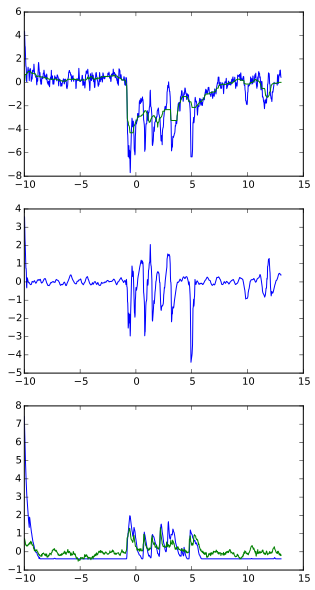

In [782]:
idx = -1
figure(figsize = (5,10))
from scipy import signal
subplot(3,1,1)
filtdata = ndata
plot(xi,ndata[idx])
trenddata = apply_along_axis(signal.medfilt,1,filtdata,kernel_size = 51)
#trenddata = apply_along_axis(flb.butter_lowpass_filter,1,filtdata,1.6,0.021)
#trenddata = apply_along_axis(signal.wiener,1,filtdata,mysize =200)
plot(xi,trenddata[idx])
subplot(3,1,2)
detrend = ndata-trenddata
#plot(xi,detrend[idx])
filtdata = apply_along_axis(signal.wiener,1,detrend,mysize =20)
plot(xi,filtdata[idx])
subplot(3,1,3)
plot(xi,get_normed_data('i1','yaw_left')[idx])
plot(xi,get_normed_data('b1','yaw_left')[idx])

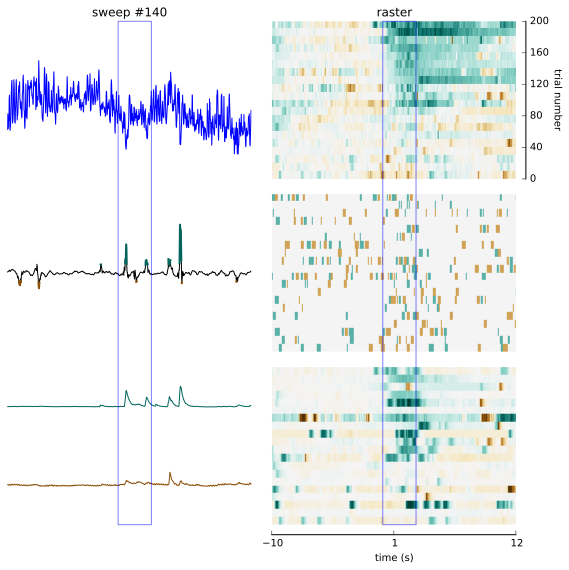

In [799]:
ims_kwargs = {'aspect':'auto','interpolation':'nearest','cmap':cm.BrBG,'extent':(-10,12,0,200)}
#fig = figure(figsize = (15,3))
thresh = 0.5
idx = 14
psaccads = filtdata > thresh
nsaccads = filtdata < thresh*-1
def plot_fun(col,row):
    #subplot(1,4,1)
    if row == 0:
        if col == 1:
            imshow(ndata[::10],vmin = -7,vmax = 7,**ims_kwargs)
        if col == 0:
            plot(xi,get_normed_data('Ph1','yaw_left')[::10][idx]*20+100)
    if row == 1:
        if col == 1:
            imshow((psaccads.astype(float) - nsaccads.astype(float))[::10],vmin = -2,vmax = 2,**ims_kwargs)
        if col == 0:
            fd = filtdata[::10][idx]
            plot(xi,fd*20+100,color = 'k')
            fd = filtdata[::10][idx].copy()
            fd[fd<thresh] = np.nan
            plot(xi,fd*20+100,color = cm.BrBG(0.9),lw = 2)
            fd = filtdata[::10][idx].copy()
            fd[fd>(thresh*-1)] = np.nan
            plot(xi,fd*20+100,color = cm.BrBG(0.1),lw = 2)
    if row == 2:
        if col == 1:
            imshow((get_normed_data('i1','yaw_left')-get_normed_data('b2','yaw_left'))[::10],
                vmin = -10,vmax = 10,**ims_kwargs)
        if col == 0:
            plot(xi,get_normed_data('i1','yaw_left')[::10][idx]*5+150,color = cm.BrBG(0.9))
            plot(xi,get_normed_data('b2','yaw_left')[::10][idx]*5+50,color = cm.BrBG(0.1))

pltrng = (-3,12)

rows = 3#len(row_keys)
cols = 2#len(col_keys)

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]
row_labels_right[0] = 'trial number'

#nsweeps = 4

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-10,12) for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [None]
#row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = ['sweep #%s'%(idx*10),'raster']

show_spines_left = False
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [6 for j in range(rows)]
xtick_numbers = [3 for i in range(cols)]

ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_fun,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = (8,8),
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False})
[ax.set_zorder(11) for ax in col_ep_pans];
savefig('saccade_comparison.pdf')

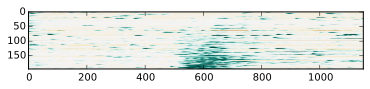

In [119]:
imshow(get_normed_data('i1','yaw_left'),cmap = cm.BrBG,vmin = -8,vmax = 8)

In [120]:
import flylib as flb

In [124]:
?flb.butter_lowpass_filter()

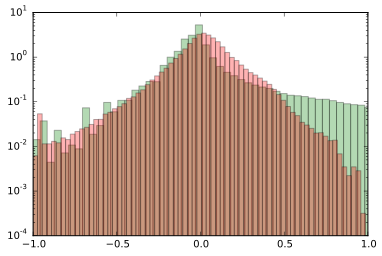

In [171]:
n, bins, patches = hist(i1_selection.ravel(),bins = 100,normed = True);
setp(patches, 'facecolor', 'g', 'alpha', 0.3)
n, bins, patches = hist(b3_selection.ravel(),bins = 100,normed = True);
setp(patches, 'facecolor', 'r', 'alpha', 0.3)
gca().set_xbound(-1,1)
gca().set_yscale('log')
#gca().set_ybound(0,3)

In [24]:
np.shape(np.mean(data_selection,axis = 1))

(196,)

In [ ]:
def get_trial_data(data,mask):
    """ Calculate the mean for each type 
    of trial - return in a dictionary keyed by signal and trial """
    #baseline_epoch = (xi >5) & (xi < 7)
    import group_data as gd
    reload(gd)
    ave_dict = dict()
    signal_set = set(data['signal_names'][mask])
    trial_set = set(data['trial_names'][mask])
    fly_set = set(data['fly_numbers'][mask])
    for signal in signal_set:
        ave_dict[signal] = dict()
        for trial in trial_set:
            ave_dict[signal][trial] = dict()
            for fly in fly_set:
                
                selection = (data['fly_numbers'] == fly) & \
                            (data['signal_names'] == signal) & \
                            (data['trial_names'] == trial) & \
                            (data['flt_samples'] > 800) & \
                            mask
                            
                if sum(selection) >0:
                    datamtrx = data['signal_data'][selection,:]
                    xi = get_xio(trial)
                    baseline_epoch = (xi >-3) & (xi < 0)
                    baseline = np.nanmean(data['signal_data'][selection][:,baseline_epoch],axis = 1)
                    datamtrx -= baseline[:,np.newaxis] #delta F
                    ave_dict[signal][trial][fly] = np.nanmean(datamtrx,axis = 0)
    return ave_dict